<a href="https://colab.research.google.com/github/DuongKhoi2162/CS114_Project_Traffic_Signs_Recognition/blob/main/Project_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Đồ án CS114: Thiết kế mô hình nhận diện biển báo giao thông sử dụng Machine Learning**

**Thành viên**

Nguyễn Trần Xuân Bách - 21520601

Lê Công Khởi Dương - 21520752

Nguyễn Minh Quân - 21521330

**Ứng dụng**: Được tích hợp vào các camera hành trình, kiểm tra các biển báo xuất hiện trên đường và báo về cho người lái để người lái xe có thể điều khiển phương tiện một cách tốt nhất



Nguồn tham khảo:

Resource Efficient Hardware Implementation for Real-Time Traffic Sign Recognition

Huai-Mao Weng, Ching-Te Chiu

Department of Electrical Engineering, National Tsing-Hua University, Hsinchu.
DOI: 10.4236/jtts.2018.83012

Đầu vào của mô hình là ảnh từ camera của xe

Ví dụ:

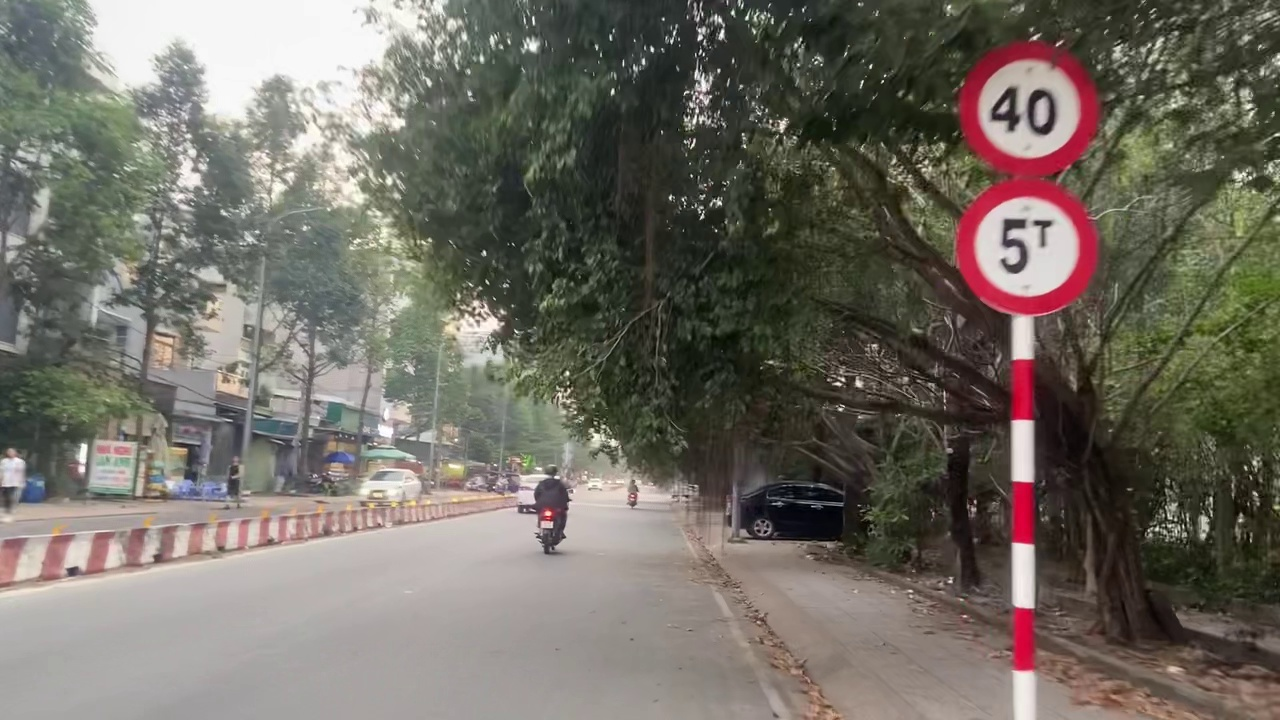



Đầu ra: Các biển báo xuất hiện trong ảnh và tên biển báo đó

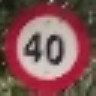
**Giới hạn 40km/h**

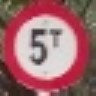
**Không vượt quá 5 tấn**

Mô hình có 2 giai đoạn: **Detection** và **Classification**

**Giai đoạn Detection**: Tìm những vị trí trong ảnh có khả năng xuất hiện biển báo

**Giai đoạn Classification**: Xác định tại vị trí đó là biển báo nào

**Khai báo thư viện**


In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import copy
from glob import glob
from sklearn.svm import SVC

# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
import PIL
import cv2
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
import xml.etree.ElementTree as ET

from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import classification_report
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, accuracy_score,confusion_matrix
from PIL import Image
from IPython.display import display




Mounted at /content/drive


**Khai báo các class**

Trong đề tài này sẽ giới hạn việc nhận diện các biển báo sau:

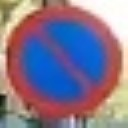
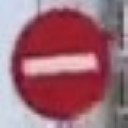
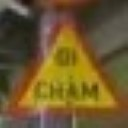
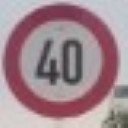
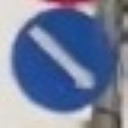

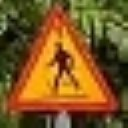
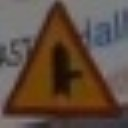
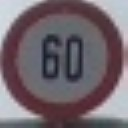
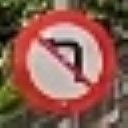
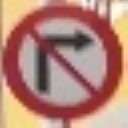

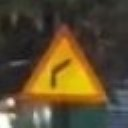
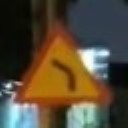
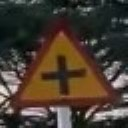
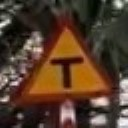
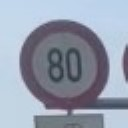

**Các biển báo trên lần lượt là:**

1.   Cấm đỗ xe
2.   Cấm đi ngược chiều
3.   Đi chậm
4.   Giới hạn 40km/h
5.   Đi hướng bên phải
6.   Cảnh báo có người qua đường
7.   Giao nhau với đường không ưu tiên
8.   Giới hạn 60km/h
9.   Cấm rẽ trái
10.  Cấm rẽ phải
11.  Đường gấp khúc sang phải
12.  Đường gấp khúc sang trái
13.  Chỗ giao nhau chữ thập
14.  Chỗ giao nhau chữ T
15.  Giới hạn 80km/h

**Các ảnh biển báo ở trên là đầu vào cho training Classification**

Tổng số lượng ảnh cho classification:

Train: 4452

Valid: 1069

Số lượng ảnh cho quá trình detection: 472

**Nguồn data**

https://www.youtube.com/watch?v=_q0aGyfRl1I(Quận 2-3-1) - 4K Walking

https://www.youtube.com/watch?v=Uw746Bv3t_E&list=PLPG4fAo48I6XOKWT_J8aUvx52rVIvaYLD&index=4 (Quận 2-3-1) - 4K Walking

https://www.youtube.com/watch?v=8LhSh54fK7Y(Quận 7) - Vietnam street 4K

https://www.youtube.com/watch?v=LEOxl7TvdQQ(Quận 7 - Gò Vấp) - Vietnam street 4K

https://www.youtube.com/watch?v=GqqC8u0EE5Y&t=405s(Quận 1) - Vietnam street 4K

https://www.youtube.com/watch?v=49Dv-q_bJw4(Thủ Đức- Quận 1) - Vietnam street 4K

https://www.youtube.com/watch?v=uSJksKaqT0Q (Thủ Đức-Bình Thạnh- Quận 1- Phú Nhuận) - 4K Walking

Video tự quay

------------------------------------------------

In [2]:
# Lưu label
folderMap = {0: 'cam_do_xe',
             1:'cam_nguoc_chieu',
             2:'di_cham',
             3:'gioi_han_40km',
             4:'huong_phai_di_vong',
             5:'can_than_nguoi_qua_duong',
             6:'giao_khong_uu_tien_phai',
             7:'gioi_han_60km',
             8:'cam_re_trai',
             9:'cam_re_phai',
             10:'duong_nghieng_phai',
             11:'duong_nghieng_trai',
             12:'giao_nhau_chu_thap',
             13:'giao_nhau_T',
             14:'gioi_han_80km',
             15:'others'}
labelNames = []
for i in range(len(folderMap)):
  labelNames.append(folderMap[i])

**Nạp data training**

In [3]:
# Nạp data train
# train_path = '/content/drive/MyDrive/TRAIN_IMG'
train_path = '/content/drive/MyDrive/train_image_classification'

x_train = []
y_train = []

start = time.time()
for i in range(len(folderMap)):
    path = train_path + '/' + str(i)
    images_path = os.listdir(path)
    # Sử dụng tqdm để tạo thanh tiến độ cho từng class
    for img_path in tqdm(images_path, desc=f'Class {folderMap[i]}'):
        try:
            img = np.array(PIL.Image.open(os.path.join(path, img_path)))
            img = cv2.cvtColor(cv2.resize(img, (32, 32)), cv2.COLOR_RGB2GRAY)
            img = hog(img,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2))
            x_train.append(img)
            # y_train.append(folderMap[i])
            y_train.append(i)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

print("Number of train img: ", len(x_train))



Class others: 100%|██████████| 819/819 [00:14<00:00, 55.56it/s] 

Number of train img:  4452


**Nạp data test**

In [4]:
# Nạp datatest
test_path = '/content/drive/MyDrive/valid_image_classification'
x_test = []
y_test = []

start = time.time()
for i in range(len(folderMap)):
    path = test_path + '/' + str(i)
    images_path = os.listdir(path)
    # Sử dụng tqdm để tạo thanh tiến độ cho từng class
    for img_path in tqdm(images_path, desc=f'Class {folderMap[i]}'):
        try:
            img = np.array(PIL.Image.open(os.path.join(path, img_path)))
            img = cv2.cvtColor(cv2.resize(img, (32, 32)), cv2.COLOR_RGB2GRAY)
            img = hog(img,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2))
            x_test.append(img)
            # y_train.append(folderMap[i])
            y_test.append(i)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

print("Number of test img: ", len(x_test))



Class others: 100%|██████████| 280/280 [00:03<00:00, 81.67it/s] 

Number of test img:  1069



**Training**

Sử dụng model SVC để thực hiện training

In [5]:
# Training
svc = SVC(probability=True, kernel='linear')
start = time.time()
svc.fit(x_train,y_train)
processTime = round(time.time()-start,2)
print("Training process has taken {} seconds".format(processTime))

Training process has taken 3.77 seconds


**Đánh giá kết quả classification**

In [6]:
# test classification
predict = svc.predict(x_test)
print(classification_report(y_test, predict, target_names=labelNames))

                          precision    recall  f1-score   support

               cam_do_xe       0.99      0.96      0.98       170
         cam_nguoc_chieu       1.00      0.99      0.99       148
                 di_cham       1.00      0.92      0.96       109
           gioi_han_40km       0.95      1.00      0.97        70
      huong_phai_di_vong       1.00      1.00      1.00         9
can_than_nguoi_qua_duong       0.65      0.89      0.75        44
 giao_khong_uu_tien_phai       0.81      0.91      0.85        32
           gioi_han_60km       0.97      0.94      0.95        62
             cam_re_trai       0.97      1.00      0.99        34
             cam_re_phai       0.97      1.00      0.98        30
      duong_nghieng_phai       1.00      0.30      0.46        10
      duong_nghieng_trai       0.94      0.88      0.91        17
      giao_nhau_chu_thap       0.33      0.05      0.09        20
             giao_nhau_T       0.76      1.00      0.86        22
         

------------------------------------------------------------------
**Các hàm phục vụ**


**Hàm NRB_Transform**

Làm nổi bật những vùng có màu xanh hoặc đỏ

In [7]:
def NRB_Transform(RGB_img):
    # Tính toán theo chiều vector hóa của NumPy
    R, G, B = RGB_img[:, :, 2].astype(np.float32), RGB_img[:, :, 1].astype(np.float32), RGB_img[:, :, 0].astype(np.float32)
    NRB = (np.maximum(R, B)) / (R + G * 4 + B + 8)
    return NRB

**Hàm CCL (Connected Component Labeling)**

Thực hiện quét ảnh để tìm những phần tử lân cận nhau

In [8]:
def CCL(binary_image):
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)
    labeled_regions = {}
    for label in range(1, len(stats)):
        labeled_regions[label] = []
        labeled_regions[label].extend(
            [(y, x) for y in range(stats[label][1], stats[label][1] + stats[label][3])
             for x in range(stats[label][0], stats[label][0] + stats[label][2])]
        )
    return labeled_regions, stats

**Đọc file XML (file lưu trữ các ground truth box của ảnh)**

In [9]:
def read_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    annotations = []

    for obj in root.findall('.//object'):
        label = obj.find('name').text
        xmin = int(obj.find('.//xmin').text)
        ymin = int(obj.find('.//ymin').text)
        xmax = int(obj.find('.//xmax').text)
        ymax = int(obj.find('.//ymax').text)

        annotations.append({'label': label, 'coordinates': (xmin, ymin, xmax, ymax)})

    return annotations

**Predict các box**

Nếu kết quả predict thuộc về 1 lớp biển báo thì lưu kết quả. Ngược lại nếu kết quả dự đoán thuộc về class Others (Không phải là biển báo mà ta đã train) thì bỏ qua

In [10]:
def predict_box(x_min, y_min, x_max, y_max, img, image, all_predictions):
    ratio = (x_max - x_min)/(y_max - y_min)
    width = x_max - x_min
    height = y_max - y_min
    if (0.75 <= ratio <= 1.25) and (21.6 <= width <= 200) and (21.6 <= height <= 200):
      cropped_image = image[y_min - 5: y_max + 5, x_min - 5:x_max + 5]
      if cropped_image.size > 0:
        cropped_image = cv2.resize(cropped_image, (32, 32))
        region_resized = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
        region_resized = hog(region_resized,
                            orientations=9,
                            pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2))
        prediction = svc.predict([region_resized])
        decision_values = svc.decision_function([region_resized])
        # print(np.max(decision_values))
        if prediction[0] < 15 :
            all_predictions.append({'label': folderMap[prediction[0]], 'coordinates': (x_min, y_min, x_max, y_max)})
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(255,0, 0), thickness=2)
            # cv2.putText(img, folderMap[prediction[0]], (x_min-15, y_min - 10), font, 3, (255, 0, 0), 2, cv2.LINE_AA)
    return img, all_predictions

**Kiểm tra - phân loại các box tìm được**

Có nhiều trường hợp các biển báo được sắp xếp khác nhau. Các biển báo có thể nằm riêng lẻ hoặc 2 biển báo được xếp chung hoặc 3 biển báo xếp chung. Dưới đây là đoạn code để xử lý 3 trường hợp đó

In [11]:
def check_box(points, img, image, all_predictions):
  y_min = min(points, key=lambda point: point[0])[0]
  x_min = min(points, key=lambda point: point[1])[1]
  y_max = max(points, key=lambda point: point[0])[0]
  x_max = max(points, key=lambda point: point[1])[1]
  if (x_max != x_min and y_max != y_min):
      width = x_max - x_min
      height = y_max - y_min
      if (height > 2.6 * width):
        x_min_box_1 = x_min
        y_min_box_1 = y_min
        x_max_box_1 = x_max
        y_max_box_1 = int(y_min + (y_max - y_min)/3)

        x_min_box_2 = x_min
        y_min_box_2 = int(y_min + (y_max - y_min)/3)
        x_max_box_2 = x_max
        y_max_box_2 = int(y_min + 2*(y_max - y_min)/3)

        x_min_box_3 = x_min
        y_min_box_3 = int(y_min + 2*(y_max - y_min)/3)
        x_max_box_3 = x_max
        y_max_box_3 = y_max

        img, all_predictions = predict_box(x_min_box_1, y_min_box_1, x_max_box_1, y_max_box_1, img, image, all_predictions)
        img, all_predictions = predict_box(x_min_box_2, y_min_box_2, x_max_box_2, y_max_box_2, img, image, all_predictions)
        img, all_predictions = predict_box(x_min_box_3, y_min_box_3, x_max_box_3, y_max_box_3, img, image, all_predictions)

      elif (height > 1.7 * width):
        x_min_box_1 = x_min
        y_min_box_1 = y_min
        x_max_box_1 = x_max
        y_max_box_1 = int(y_min + (y_max - y_min)/2)
        x_min_box_2 = x_min
        y_min_box_2 = int(y_min + (y_max - y_min)/2)
        x_max_box_2 = x_max
        y_max_box_2 = y_max
        img, all_predictions = predict_box(x_min_box_1, y_min_box_1, x_max_box_1, y_max_box_1, img, image, all_predictions)
        img, all_predictions = predict_box(x_min_box_2, y_min_box_2, x_max_box_2, y_max_box_2, img, image, all_predictions)
      else:
        img, all_predictions = predict_box(x_min, y_min, x_max, y_max, img, image, all_predictions)
  return img, all_predictions


**Nạp hình biển báo để hiển thị kết quả**

In [12]:


# Đường dẫn đến thư mục chứa hình ảnh
thu_muc_hinh = "/content/drive/MyDrive/image_show"

# Kiểm tra xem thư mục có tồn tại không
if not os.path.exists(thu_muc_hinh):
    print(f"Thư mục '{thu_muc_hinh}' không tồn tại.")
    exit()

# Lấy danh sách các tệp trong thư mục
danh_sach_tep = sorted(os.listdir(thu_muc_hinh))

# Lọc ra các tệp hình ảnh
danh_sach_hinh = [tep for tep in danh_sach_tep if tep.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Khởi tạo mảng image_list để lưu trữ hình ảnh
image_list = []

# Đọc hình ảnh và thêm vào mảng
for ten_tep in danh_sach_hinh:
    duong_dan_tep = os.path.join(thu_muc_hinh, ten_tep)
    try:
        hinh_anh = Image.open(duong_dan_tep)
        image_list.append(hinh_anh)
    except Exception as e:
        print(f"Không thể đọc hình ảnh '{ten_tep}': {e}")

# In ra số lượng hình ảnh đã đọc được
print(f"Số lượng hình ảnh đã đọc: {len(image_list)}")


Số lượng hình ảnh đã đọc: 15


-----------------
**FLOW thực hiện**

Dưới đây là quy trình xử lý của bài toán

In [13]:
image = cv2.imread('/content/drive/MyDrive/image_detect/frame (117).jpg')
# Chuyển ảnh sang RGB
image = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
img = copy.copy(image)


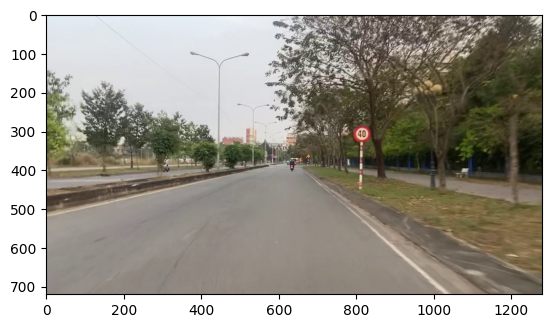

In [14]:
plt.imshow(image)
plt.show()


In [15]:
# Làm mờ ảnh với GaussianBlur
blurred_image = cv2.GaussianBlur(image, (7, 7), 0)
# Normalize RB
image_NRB = NRB_Transform(blurred_image)

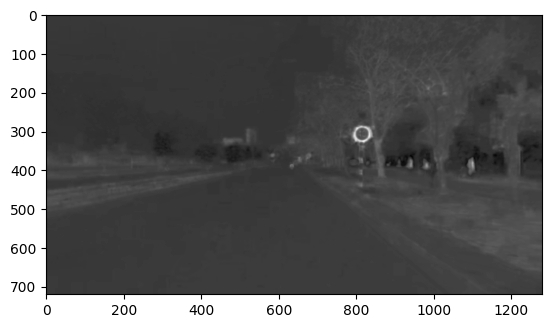

In [16]:
plt.imshow(image_NRB, cmap=plt.cm.gray)
plt.show()

In [17]:
# Áp Threshhold lên ảnh
_, binary_image = cv2.threshold(image_NRB, 0.23, 1, cv2.THRESH_BINARY)
# Chuyển giá trị pixel thành kiểu 8 bit khong dấu
binary_image = np.uint8(binary_image)


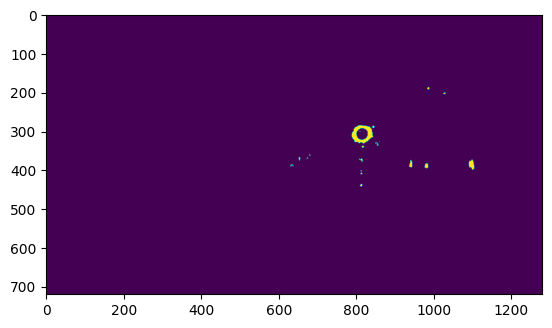

In [18]:
plt.imshow(binary_image)
plt.show()


['gioi_han_40km']


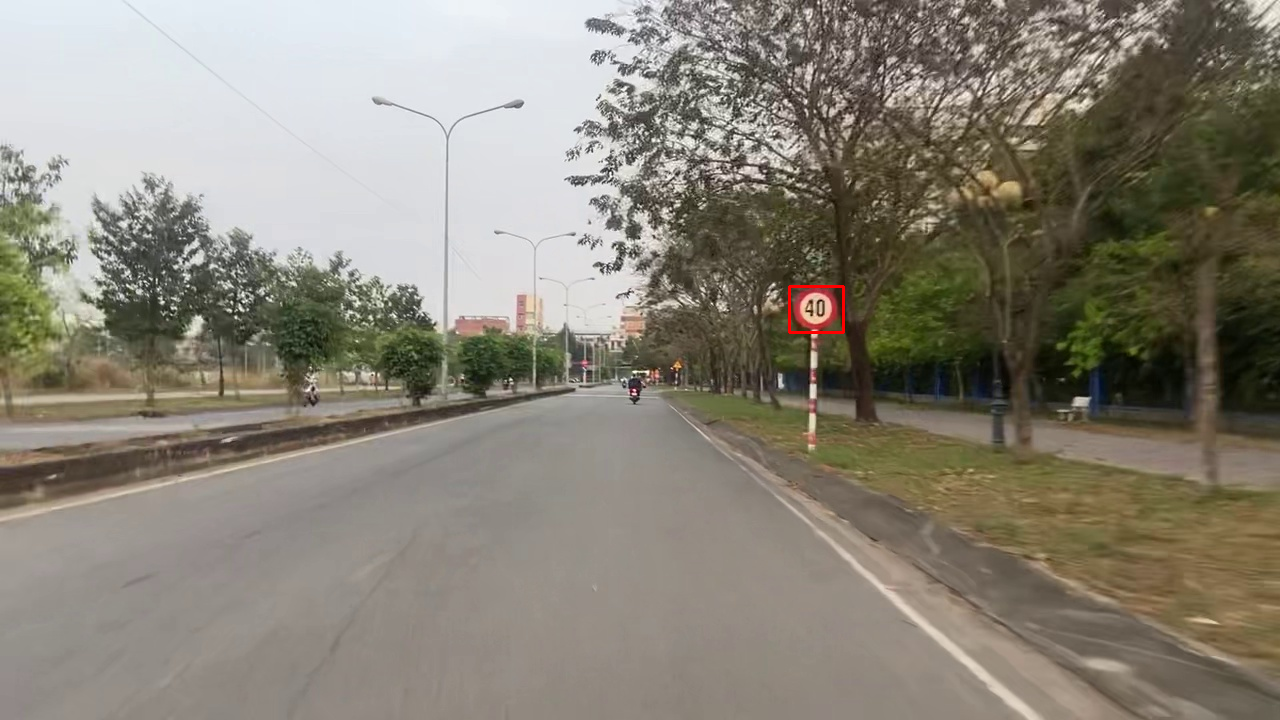

In [19]:
# Áp dụng CCL
labeled_regions, _ = CCL(binary_image)

# Mảng lưu các kết quả predict (label and coordinates)
all_predictions = []

# Vẽ bounding box cho từng vùng liên thông và cắt ảnh
for _, points in labeled_regions.items():
    img, all_predictions = check_box(points, img, image, all_predictions)

all_predictions_indices = [item['label'] for item in all_predictions]

print(all_predictions_indices)
predicted_indices = [next(key for key, value in folderMap.items() if value == prediction) for prediction in all_predictions_indices]
# print(predicted_indices)


display(Image.fromarray(img))

# for i in predicted_indices:
#   display(image_list[i])
#   print(folderMap[i])


**Đánh giá kết quả của toàn bộ quá trình Detection và Classification**

Dưới đây là đoạn code dùng để đánh giá kết quả của toàn bộ mô hình

In [20]:
# Đường dẫn đến thư mục chứa ảnh và các tệp XML
image_folder_path = '/content/drive/MyDrive/image_detect'
xml_folder_path = '/content/drive/MyDrive/annot_detect'
font = cv2.FONT_HERSHEY_SIMPLEX
predict_all = []
truth_all = []

# Lấy danh sách tên tệp ảnh trong thư mục
image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.jpg')]
sum_accuracy = 0
num_images = len(image_files)
for num,image_file in enumerate(image_files):
    # print(num, image_file)
    begin = time.time()
    # Đường dẫn đầy đủ cho ảnh và XML tương ứng
    image_path = os.path.join(image_folder_path, image_file)
    xml_path = os.path.join(xml_folder_path, image_file.replace('.jpg', '.xml'))
    if not os.path.exists(xml_path):
        print(f"WARNING: Tệp XML không tồn tại cho ảnh {image_file}. Bỏ qua.")
        continue
    # Đọc ảnh từ đường dẫn
    image = cv2.imread(image_path)
    # Đọc file annotation từ đường dẫn
    annotations = read_xml(xml_path)
    # Chuyển ảnh sang RGB
    image = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #copy ảnh
    img = copy.copy(image)
    # Làm mờ ảnh với GaussianBlur
    blurred_image = cv2.GaussianBlur(image, (7, 7), 0)
    # Normalize RGB
    image_NRB = NRB_Transform(blurred_image)

    # Áp Threshhold lên ảnh
    _, binary_image = cv2.threshold(image_NRB, 0.23, 255, cv2.THRESH_BINARY)
    # Chuyển giá trị pixel thành kiểu 8 bit khong dấu
    binary_image = np.uint8(binary_image)

    # Áp dụng CCL
    labeled_regions, stats = CCL(binary_image)

    # Mảng lưu các kết quả predict (label and coordinates)
    all_predictions = []

    # Vẽ bounding box cho từng vùng liên thông và cắt ảnh
    for _, points in labeled_regions.items():
        _, all_predictions = check_box(points, img, image, all_predictions)

    # accuracy, annotations_indices, all_predictions_indices = calculate_accuracy(all_predictions,annotations)
    # sum_accuracy += accuracy
    predict_num = list(np.zeros(15, dtype=int))
    truth_num = list(np.zeros(15, dtype=int))

    annotations_indices = [item['label'] for item in annotations]
    all_predictions_indices = [item['label'] for item in all_predictions]

    # Chuyển đổi tên các lớp trong predict và truth thành số tương ứng
    for i, label in folderMap.items():
        if label in all_predictions_indices:
            predict_num[i] = 1
        if label in annotations_indices:
            truth_num[i] = 1
    predict_all.append(predict_num)
    truth_all.append(truth_num)



print('Number of images: ', num_images)
# print('Average accuracy: ', sum_accuracy/num_images)
precision = precision_score(np.array(predict_all), np.array(truth_all), average=None, zero_division=1)
recall = recall_score(np.array(predict_all), np.array(truth_all), average=None, zero_division=1 )
f1 = f1_score(np.array(predict_all), np.array(truth_all), average=None, zero_division=1)
print(f'Average precision: {np.mean(precision)}')
print(f'Average recall   : {np.mean(recall)}')
print(f'Average f1       : {np.mean(f1)}')
# Display the results
# Create a DataFrame for results
results_df = pd.DataFrame({
    'Label': [f"{folderMap[i]}" for i in range(len(precision))],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})
# Print the DataFrame

print(results_df)

Number of images:  472
Average precision: 0.5295867672483504
Average recall   : 0.5399823488546035
Average f1       : 0.5142660992094571
                       Label  Precision    Recall  F1-Score
0                  cam_do_xe   0.725490  0.451220  0.556391
1            cam_nguoc_chieu   0.597015  0.597015  0.597015
2                    di_cham   0.318182  0.538462  0.400000
3              gioi_han_40km   0.666667  0.666667  0.666667
4         huong_phai_di_vong   0.425926  0.851852  0.567901
5   can_than_nguoi_qua_duong   0.600000  0.340909  0.434783
6    giao_khong_uu_tien_phai   0.548387  0.531250  0.539683
7              gioi_han_60km   0.343750  0.458333  0.392857
8                cam_re_trai   0.835052  0.964286  0.895028
9                cam_re_phai   0.688889  0.837838  0.756098
10        duong_nghieng_phai   1.000000  0.800000  0.888889
11        duong_nghieng_trai   0.500000  0.428571  0.461538
12        giao_nhau_chu_thap   0.333333  0.133333  0.190476
13               giao_n

In [21]:
def swap_confusion_matrix(matrix):
  # Thay đổi các giá trị
  a_new = matrix[1, 1]
  b_new = matrix[1, 0]
  c_new = matrix[0, 1]
  d_new = matrix[0, 0]

# Cập nhật ma trận với các giá trị mới
  matrix[0, 0] = a_new
  matrix[0, 1] = b_new
  matrix[1, 0] = c_new
  matrix[1, 1] = d_new
  return matrix


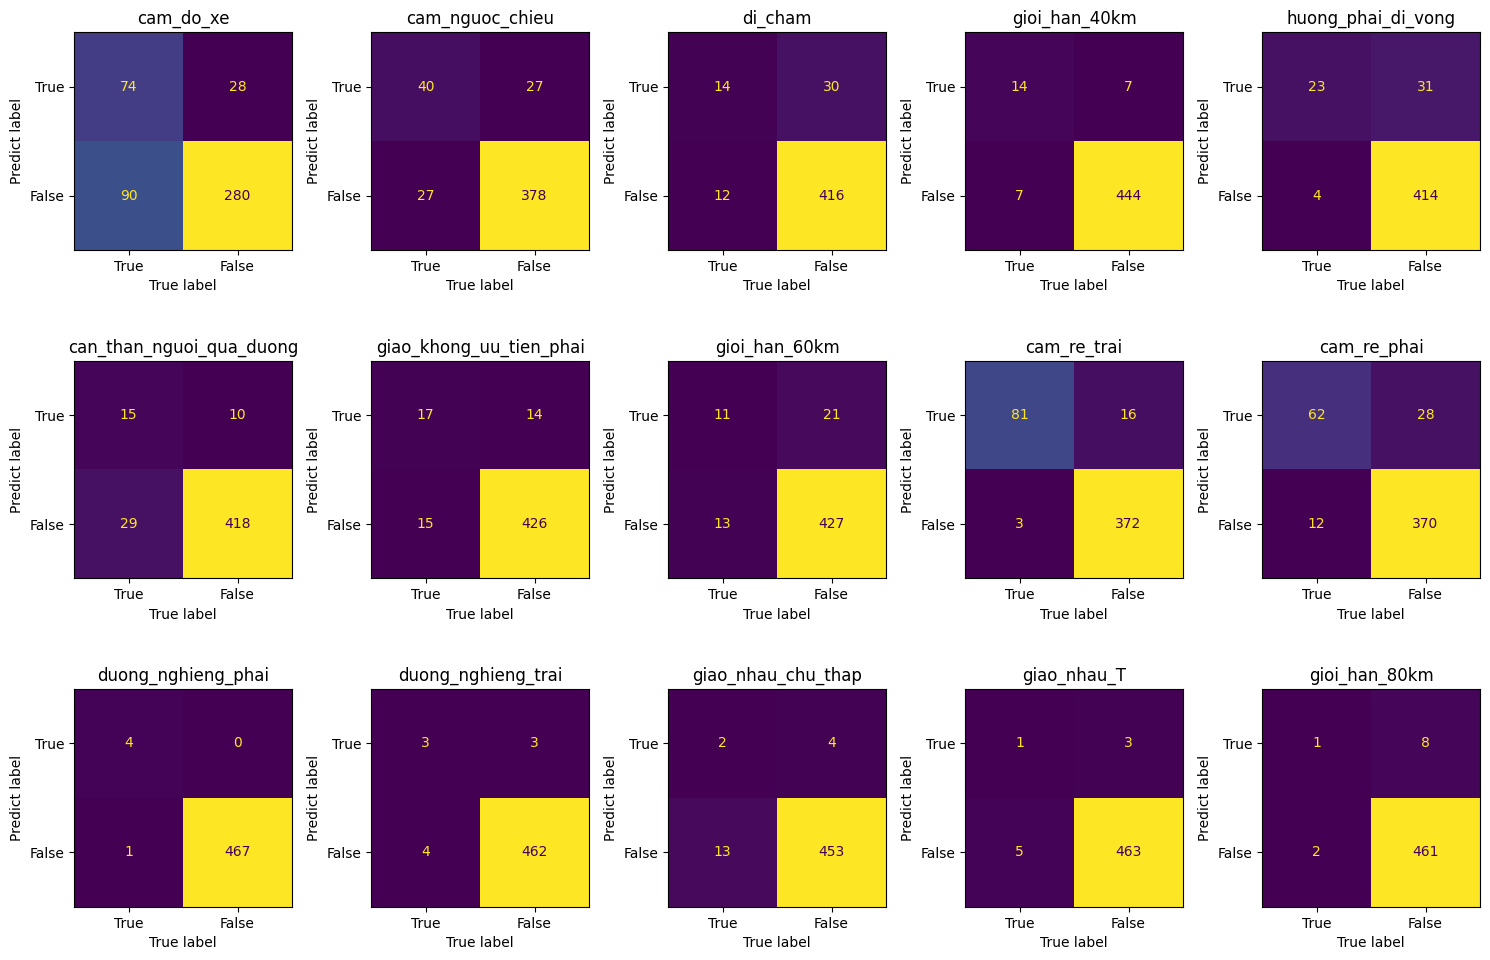

In [22]:
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix, ConfusionMatrixDisplay
truth_all = np.array(truth_all)
predict_all = np.array(predict_all)
truth_all = truth_all.astype(str)
predict_all = predict_all.astype(str)
truth = []
predict = []

num_rows = 3
num_cols = 5

total_matrices = num_rows * num_cols
num_matrices = min(total_matrices, truth_all.shape[1])

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.ravel()

for j in range(num_matrices):
    truth = truth_all[:, j]
    predict = predict_all[:, j]

    cm = confusion_matrix(truth, predict)
    swap_cm = swap_confusion_matrix(cm)

    cm_display = ConfusionMatrixDisplay(confusion_matrix=swap_cm, display_labels=[True, False])
    cm_display.plot(ax=axes[j])
    cm_display.im_.colorbar.remove()

    axes[j].set_title(labelNames[j])
    axes[j].set_xlabel("True label")
    axes[j].set_ylabel("Predict label")
    axes[j].set_xticklabels(["True", "False"])
    axes[j].set_yticklabels(["True", "False"])

for j in range(num_matrices, total_matrices):
    axes[j].axis("off")
plt.tight_layout()
plt.show()

-----------------
**DETECT VÀ CLASSIFICATION TRÊN ẢNH**

**Test ảnh**

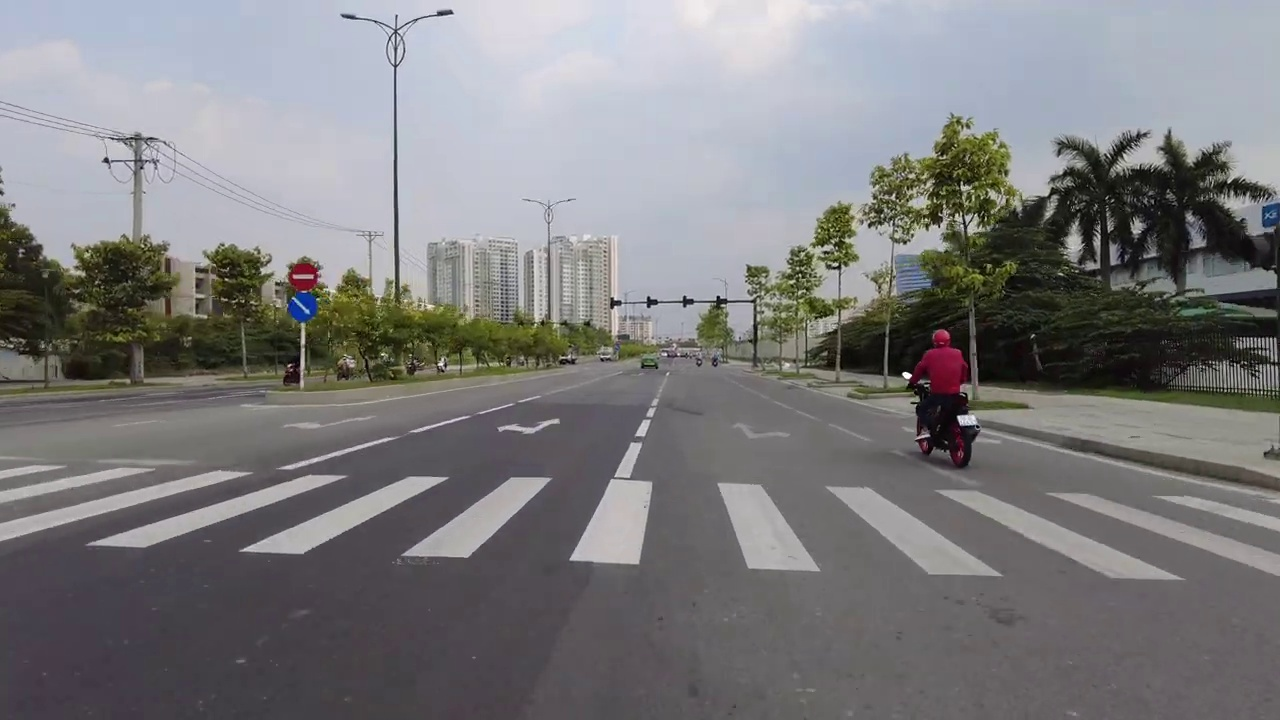

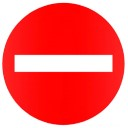

cam_nguoc_chieu


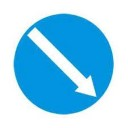

huong_phai_di_vong
Time: 0.34732770919799805s


In [23]:
begin = time.time()
image = cv2.imread('/content/drive/MyDrive/image_detect/105.jpg')
# Chuyển ảnh sang RGB
image = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#copy ảnh
# img = copy.copy(image)
# Làm mờ ảnh với GaussianBlur
blurred_image = cv2.GaussianBlur(image, (7, 7), 0)
# Normalize RGB
image_NRB = NRB_Transform(blurred_image)

# Áp Threshhold lên ảnh
_, binary_image = cv2.threshold(image_NRB, 0.23, 255, cv2.THRESH_BINARY)
# Chuyển giá trị pixel thành kiểu 8 bit khong dấu
binary_image = np.uint8(binary_image)

# Áp dụng CCL
labeled_regions, stats = CCL(binary_image)

# Mảng lưu các kết quả predict (label and coordinates)
all_predictions = []

# Vẽ bounding box cho từng vùng liên thông và cắt ảnh
for _, points in labeled_regions.items():
    _, all_predictions = check_box(points, _, image, all_predictions)

all_predictions_indices = [item['label'] for item in all_predictions]

# print(all_predictions_indices)
predicted_indices = [next(key for key, value in folderMap.items() if value == prediction) for prediction in all_predictions_indices]
# print(predicted_indices)


display(Image.fromarray(image))

for i in predicted_indices:
  display(image_list[i])
  print(folderMap[i])
# plt.imshow(binary_image)
# plt.show()

print(f'Time: {time.time()-begin}s')




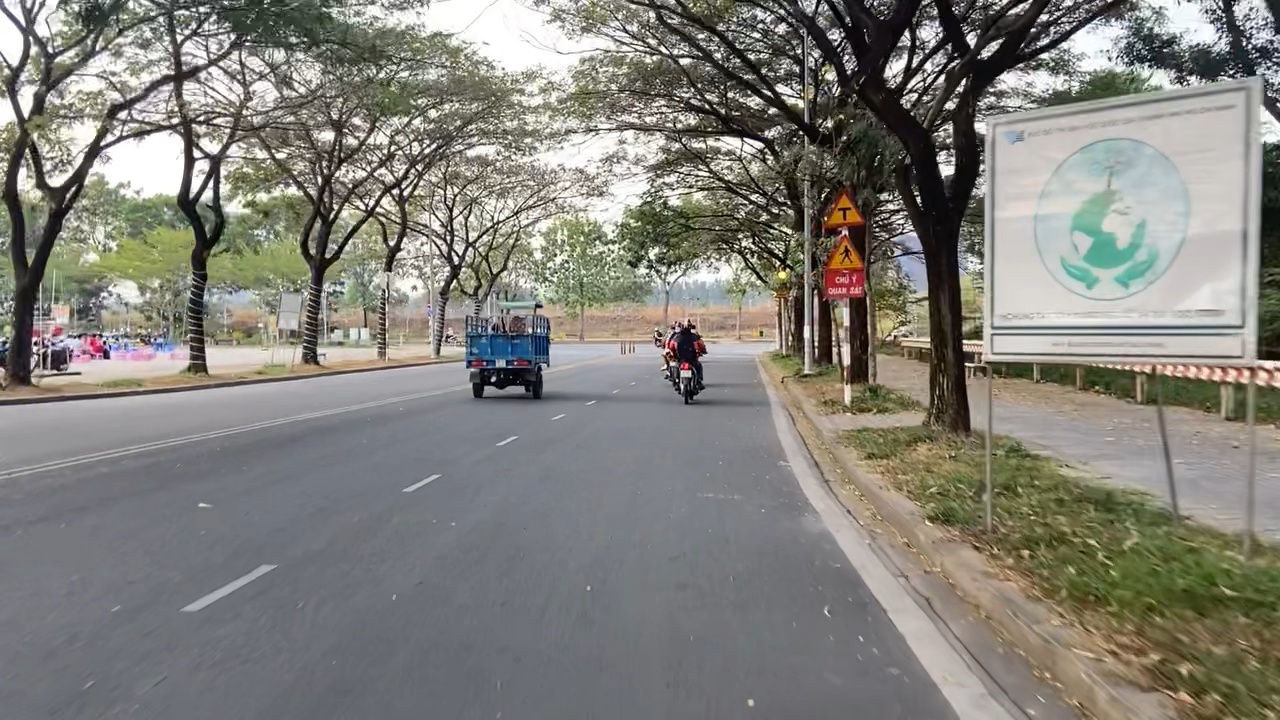

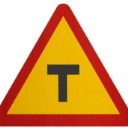

giao_nhau_T
Time: 0.573298454284668s


In [24]:
begin = time.time()
image = cv2.imread('/content/drive/MyDrive/image_detect/frame_1916.jpg')
# Chuyển ảnh sang RGB
image = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#copy ảnh
# img = copy.copy(image)
# Làm mờ ảnh với GaussianBlur
blurred_image = cv2.GaussianBlur(image, (7, 7), 0)
# Normalize RGB
image_NRB = NRB_Transform(blurred_image)

# Áp Threshhold lên ảnh
_, binary_image = cv2.threshold(image_NRB, 0.23, 255, cv2.THRESH_BINARY)
# Chuyển giá trị pixel thành kiểu 8 bit khong dấu
binary_image = np.uint8(binary_image)

# Áp dụng CCL
labeled_regions, stats = CCL(binary_image)

# Mảng lưu các kết quả predict (label and coordinates)
all_predictions = []

# Vẽ bounding box cho từng vùng liên thông và cắt ảnh
for _, points in labeled_regions.items():
    _, all_predictions = check_box(points, _, image, all_predictions)

all_predictions_indices = [item['label'] for item in all_predictions]

# print(all_predictions_indices)
predicted_indices = [next(key for key, value in folderMap.items() if value == prediction) for prediction in all_predictions_indices]
# print(predicted_indices)


display(Image.fromarray(image))

for i in predicted_indices:
  display(image_list[i])
  print(folderMap[i])
# plt.imshow(binary_image)
# plt.show()

print(f'Time: {time.time()-begin}s')




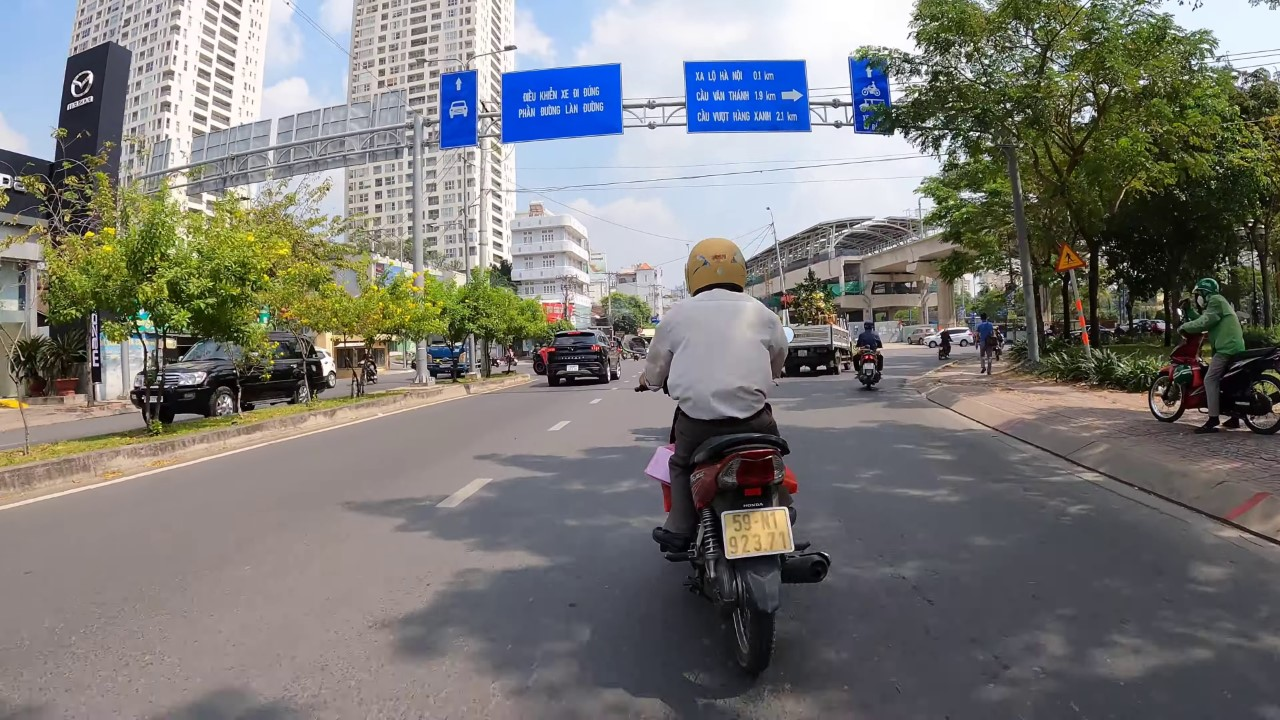

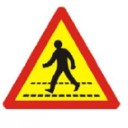

can_than_nguoi_qua_duong
Time: 0.41733646392822266s


In [25]:
begin = time.time()
image = cv2.imread('/content/drive/MyDrive/image_detect/dt_test (36).jpg')
# Chuyển ảnh sang RGB
image = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#copy ảnh
# img = copy.copy(image)
# Làm mờ ảnh với GaussianBlur
blurred_image = cv2.GaussianBlur(image, (7, 7), 0)
# Normalize RGB
image_NRB = NRB_Transform(blurred_image)

# Áp Threshhold lên ảnh
_, binary_image = cv2.threshold(image_NRB, 0.23, 255, cv2.THRESH_BINARY)
# Chuyển giá trị pixel thành kiểu 8 bit khong dấu
binary_image = np.uint8(binary_image)

# Áp dụng CCL
labeled_regions, stats = CCL(binary_image)

# Mảng lưu các kết quả predict (label and coordinates)
all_predictions = []

# Vẽ bounding box cho từng vùng liên thông và cắt ảnh
for _, points in labeled_regions.items():
    _, all_predictions = check_box(points, _, image, all_predictions)

all_predictions_indices = [item['label'] for item in all_predictions]

# print(all_predictions_indices)
predicted_indices = [next(key for key, value in folderMap.items() if value == prediction) for prediction in all_predictions_indices]
# print(predicted_indices)


display(Image.fromarray(image))

for i in predicted_indices:
  display(image_list[i])
  print(folderMap[i])
# plt.imshow(binary_image)
# plt.show()

print(f'Time: {time.time()-begin}s')




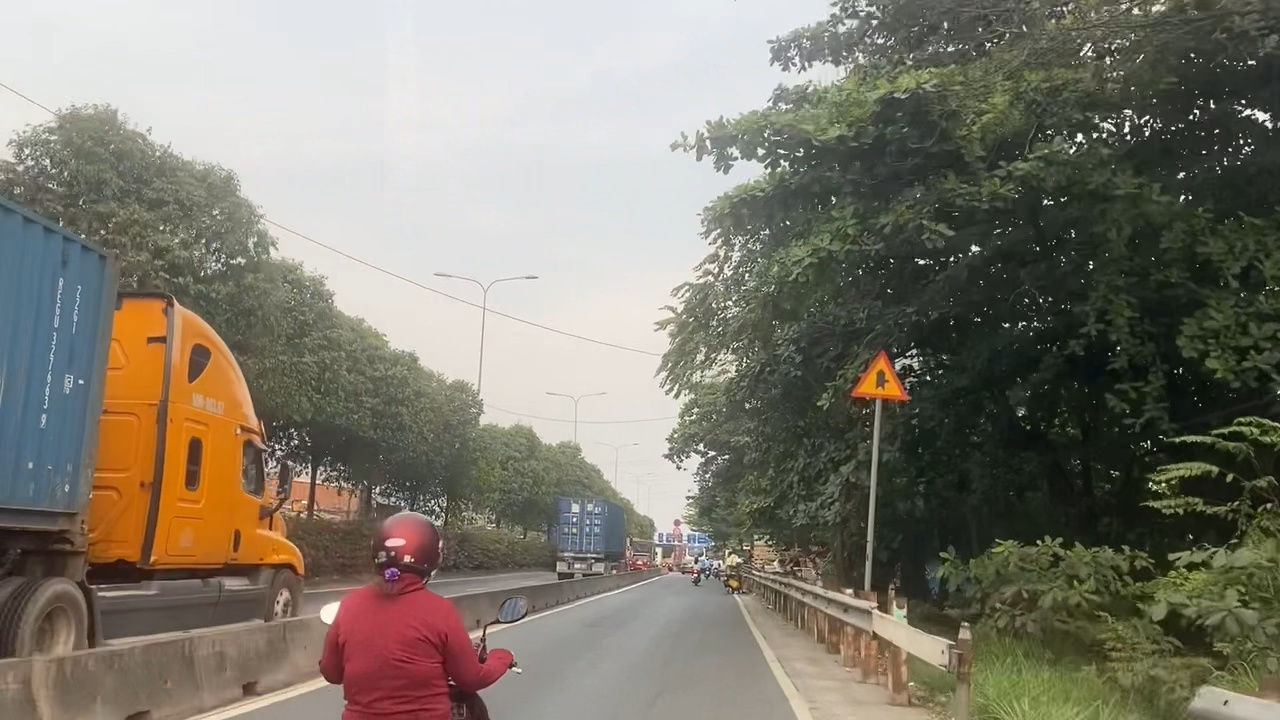

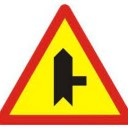

giao_khong_uu_tien_phai
Time: 0.443617582321167s


In [26]:
begin = time.time()
image = cv2.imread('/content/drive/MyDrive/image_detect/frame_566.jpg')
# Chuyển ảnh sang RGB
image = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#copy ảnh
# img = copy.copy(image)
# Làm mờ ảnh với GaussianBlur
blurred_image = cv2.GaussianBlur(image, (7, 7), 0)
# Normalize RGB
image_NRB = NRB_Transform(blurred_image)

# Áp Threshhold lên ảnh
_, binary_image = cv2.threshold(image_NRB, 0.23, 255, cv2.THRESH_BINARY)
# Chuyển giá trị pixel thành kiểu 8 bit khong dấu
binary_image = np.uint8(binary_image)

# Áp dụng CCL
labeled_regions, stats = CCL(binary_image)

# Mảng lưu các kết quả predict (label and coordinates)
all_predictions = []

# Vẽ bounding box cho từng vùng liên thông và cắt ảnh
for _, points in labeled_regions.items():
    _, all_predictions = check_box(points, _, image, all_predictions)

all_predictions_indices = [item['label'] for item in all_predictions]

# print(all_predictions_indices)
predicted_indices = [next(key for key, value in folderMap.items() if value == prediction) for prediction in all_predictions_indices]
# print(predicted_indices)


display(Image.fromarray(image))

for i in predicted_indices:
  display(image_list[i])
  print(folderMap[i])
# plt.imshow(binary_image)
# plt.show()

print(f'Time: {time.time()-begin}s')




[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


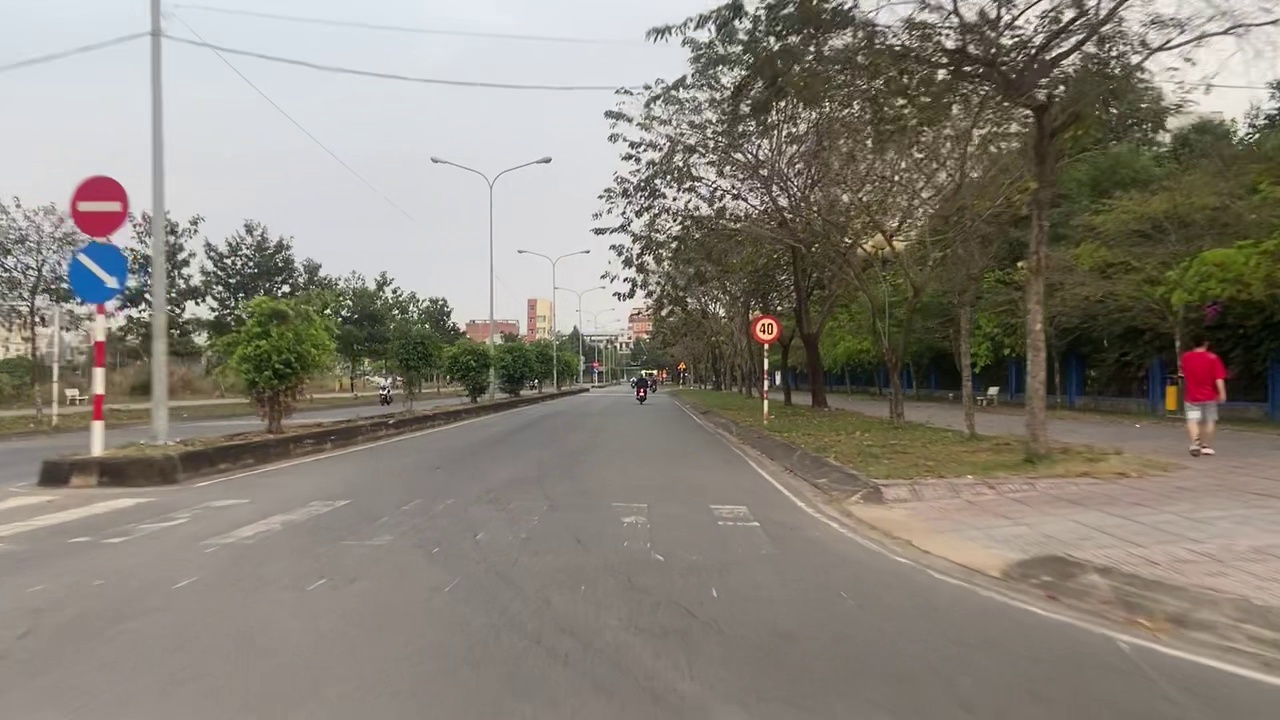

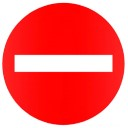

cam_nguoc_chieu


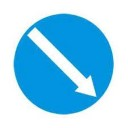

huong_phai_di_vong


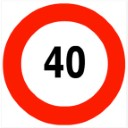

gioi_han_40km


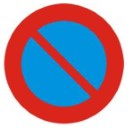

cam_do_xe
Time: 0.4751005172729492s


In [27]:
begin = time.time()
image = cv2.imread('/content/drive/MyDrive/image_detect/frame (95).jpg')
# Chuyển ảnh sang RGB
image = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#copy ảnh
# img = copy.copy(image)
# Làm mờ ảnh với GaussianBlur
blurred_image = cv2.GaussianBlur(image, (7, 7), 0)
# Normalize RGB
image_NRB = NRB_Transform(blurred_image)

# Áp Threshhold lên ảnh
_, binary_image = cv2.threshold(image_NRB, 0.23, 255, cv2.THRESH_BINARY)
# Chuyển giá trị pixel thành kiểu 8 bit khong dấu
binary_image = np.uint8(binary_image)

# Áp dụng CCL
labeled_regions, stats = CCL(binary_image)

# Mảng lưu các kết quả predict (label and coordinates)
all_predictions = []

# Vẽ bounding box cho từng vùng liên thông và cắt ảnh
for _, points in labeled_regions.items():
    _, all_predictions = check_box(points, _, image, all_predictions)

all_predictions_indices = [item['label'] for item in all_predictions]
predict_num = list(np.zeros(15, dtype=int))
# predict_all
# print(all_predictions_indices)
predicted_indices = [next(key for key, value in folderMap.items() if value == prediction) for prediction in all_predictions_indices]
# print(predicted_indices)
for i, label in folderMap.items():
        if label in all_predictions_indices:
            predict_num[i] = 1

    # predict_all.append(predict_num)
print(predict_num)
display(Image.fromarray(image))

for i in predicted_indices:
  display(image_list[i])
  print(folderMap[i])
# plt.imshow(binary_image)
# plt.show()

print(f'Time: {time.time()-begin}s')




In [ ]:
# precision = []
# recall = []
# thresholds = []
# print(truth_all[:0])
# for i in range(15):
#     truth_elements = [sublist[i] for sublist in truth_all]
#     predict_elements = [sublist[i] for sublist in predict_all]
#     prec_i, recall_i, thresholds_i = precision_recall_curve(truth_elements, predict_elements)
#     precision.append(prec_i)
#     recall.append(recall_i)
#     thresholds.append(thresholds_i)

# plt.figure(figsize=(16, 12))
# for i in range(15):
#     plt.plot(recall[i], precision[i], label=f'{folderMap[i]}')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve (Multi-class)')
# plt.show()